# Part 1: Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import lightgbm as lgb
from statistics import mean, median
import statsmodels.api as sma
from scipy.stats import kurtosis
from scipy.stats import norm
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import joblib


In [ ]:
! git clone -b my-model https://github.com/MaiTran101/ML2_project.git

Cloning into 'ML2_project'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 49 (delta 9), reused 13 (delta 7), pack-reused 32 (from 1)
Receiving objects: 100% (49/49), 21.07 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
import os
os.listdir("ML2_project")


['y_test_full.joblib',
 'X_test_final.joblib',
 'X_train_full_enc.joblib',
 'cv_folds.joblib',
 'y_train_full.joblib',
 'LightGBM.ipynb',
 '.git',
 'XGB.ipynb']

In [ ]:
# load transformed folds from XGB
data = joblib.load("ML2_project/cv_folds.joblib")

# unpack the dictionary
X_train_folds = data["X_train_folds"]
y_train_folds = data["y_train_folds"]
X_val_folds   = data["X_val_folds"]
y_val_folds   = data["y_val_folds"]

In [ ]:
# sanity check
print("Number of folds")
print(len(X_train_folds))

print("Shapes of training folds")
print(X_train_folds[0].shape)

print("Shapes of validation folds")
print(X_val_folds[0].shape)


Number of folds
7
Shapes of training folds
(1461, 83)
Shapes of validation folds
(1461, 83)


In [ ]:
# features in each fold
print("All features across folds:")
print(X_train_folds[0].columns.tolist())

All features across folds:
['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'hour', 'day_of_week', 'month', 'day_of_month', 'is_weekend', 'time_period', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'lights_te_mean', 'lights_te_median', 'time_period_te_mean', 'time_period_te_median', 'hour_te_median', 'hour_te_mean', 'month_te_mean', 'month_te_median', 'T2_bin_te_mean', 'T3_bin_te_mean', 'T8_bin_te_mean', 'T1_bin_te_mean', 'RH_8_bin_te_mean', 'RH_6_bin_te_mean', 'T4_bin_te_mean', 'T6_bin_te_mean', 'RH_out_bin_te_mean', 'T5_bin_te_mean', 'T7_bin_te_mean', 'T_out_bin_te_mean', 'T9_bin_te_mean', 'RH_9_bin_te_mean', 'RH_7_bin_te_mean', 'RH_1_bin_te_mean', 'RH_2_bin_te_mean', 'Press_mm_hg_bin_te_mean', 'T2_bin_te_median', 'T3_bin_te_median', 'T8_bin_t

## Correlation and MI score for folds

In [ ]:
# Compute MI fold by fold
mi_scores_folds = []

for X_train, y_train in zip(X_train_folds, y_train_folds):
    # Make sure all columns are numeric (MI requires numeric input)
    X_train_numeric = X_train.select_dtypes(include=[np.number])

    # Compute MI between each feature and target
    mi = mutual_info_regression(X_train_numeric, y_train, random_state=42)

    # Convert to Series with feature names
    mi_series = pd.Series(mi, index=X_train_numeric.columns)

    mi_scores_folds.append(mi_series)

# Concatenate MI from all folds
mi_df = pd.concat(mi_scores_folds, axis=1)

# Take mean across folds
mi_mean = mi_df.mean(axis=1).sort_values(ascending=False)

print("Top features by MI:")
print(mi_mean.head(10))

Top features by MI:
time_period_te_mean    0.321039
hour                   0.303419
lights_te_mean         0.284576
hour_te_mean           0.278137
hour_te_median         0.220189
T3_bin_te_mean         0.204954
Press_mm_hg            0.197903
T2_bin_te_mean         0.190331
time_period            0.188593
RH_8_bin_te_mean       0.181801
dtype: float64


In [ ]:
# Store correlation series for each fold
correlations_folds = []

for X_train, y_train in zip(X_train_folds, y_train_folds):
    # Combine X and y temporarily for correlation
    df_fold = X_train.copy()
    df_fold["target"] = y_train.values

    # Compute correlation of all features with target
    corr = df_fold.corr()["target"].drop("target")

    correlations_folds.append(corr)

# Concatenate all correlations into a DataFrame
corr_df = pd.concat(correlations_folds, axis=1)

# Take mean across folds
mean_corr = corr_df.mean(axis=1)

# Sort by absolute value
mean_corr = mean_corr.sort_values(key=lambda s: s.abs(), ascending=False)

print(mean_corr.head(10))

hour_te_mean             0.491504
hour_te_median           0.458440
lights_te_mean           0.438522
lights_te_median         0.429272
lights                   0.402298
time_period_te_mean      0.400210
time_period_te_median    0.367706
hour                     0.355512
hour_sin                -0.350227
T2_bin_te_mean           0.231880
dtype: float64


# Part 2. Training model on folds and Feature Selection

In [ ]:
def rolling_cv_lightgbm_random_rmse(
    X_train_folds,
    y_train_folds,
    X_val_folds,
    y_val_folds,
    n_iter=20,
    n_jobs=-1,
    verbose=-1
):
    """
    Rolling CV for LightGBM using pre-split folds.
    Optimizes RMSE and reports MAE.
    """

    # Build CV splits and concatenate data

    cv_splits = []
    X_all = []
    y_all = []

    cursor = 0
    for X_tr, y_tr, X_va, y_va in zip(
        X_train_folds, y_train_folds, X_val_folds, y_val_folds
    ):
        X_all.extend([X_tr, X_va])
        y_all.extend([y_tr, y_va])

        n_tr = len(X_tr)
        n_va = len(X_va)

        train_idx = np.arange(cursor, cursor + n_tr)
        val_idx = np.arange(cursor + n_tr, cursor + n_tr + n_va)

        cv_splits.append((train_idx, val_idx))
        cursor += n_tr + n_va

    X_all = pd.concat(X_all, ignore_index=True)
    y_all = pd.concat(y_all, ignore_index=True)

    # Base model

    lgbm = lgb.LGBMRegressor(
        objective="regression",
        random_state=42,
        n_jobs=n_jobs,
        verbose=verbose,
    )

    # Hyperparameter space

    param_distributions = {
        "num_leaves": [90, 100, 110, 120],
        "max_depth": [5, 6, 7],
        "learning_rate": [0.005, 0.01, 0.015, 0.02],
        "n_estimators": [400, 500, 600],
        "min_data_in_leaf": [50, 60, 70],
        "feature_fraction": [0.65, 0.7, 0.75, 0.8],
        "bagging_fraction": [0.8, 0.85, 0.9],
        "bagging_freq": [1],
        "lambda_l1": [0.0, 0.05, 0.1],
        "lambda_l2": [1.2, 1.5, 1.8],
        "device_type": ["cpu"]
    }

    # RandomizedSearchCV

    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_splits,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=42
    )

    random_search.fit(X_all, y_all)

    best_model = random_search.best_estimator_
    best_rmse = -random_search.best_score_

    # Fast + correct MAE computation

    from sklearn.base import clone

    mae_list = []

    for train_idx, val_idx in cv_splits:
        model = clone(best_model)

        model.fit(
            X_all.iloc[train_idx],
            y_all.iloc[train_idx]
        )

        y_pred = model.predict(X_all.iloc[val_idx])
        mae_list.append(
            mean_absolute_error(y_all.iloc[val_idx], y_pred)
        )

    mean_mae = np.mean(mae_list)

    # Output

    cv_results_df = pd.DataFrame({
        "cv_rmse": [best_rmse],
        "cv_mae": [mean_mae]
    })

    print("Best parameters:", random_search.best_params_)
    print(f"Best CV RMSE: {best_rmse:.4f}")
    print(f"Best CV MAE:  {mean_mae:.4f}")

    return best_model, random_search, cv_results_df


In [ ]:
best_lgbm, random_lgbm, _= rolling_cv_lightgbm_random_rmse(
    X_train_folds=X_train_folds,
    y_train_folds=y_train_folds,
    X_val_folds=X_val_folds,
    y_val_folds=y_val_folds,
    n_iter=20,
    n_jobs=1,
    verbose=1
)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
def get_feature_importance_df(model, feature_names):
    importances = model.feature_importances_
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    return fi_df

def plot_feature_importances(fi_df, model_name="Model", top_n=None, figsize=(8, 6)):
    if top_n is not None:
        fi_df = fi_df.head(top_n)

    plt.figure(figsize=figsize)
    plt.barh(fi_df["feature"], fi_df["importance"])
    plt.gca().invert_yaxis() # highest importance at top
    plt.xlabel("Importance")
    plt.title(f"{model_name} Feature Importances")
    plt.tight_layout()
    plt.show()

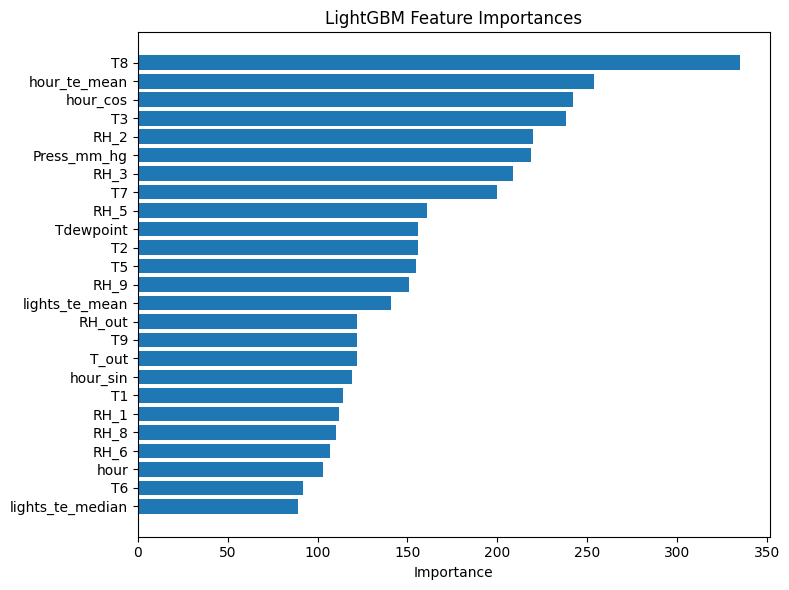

In [ ]:
# feature importance
feature_importance_lgbm = get_feature_importance_df(best_lgbm, X_train_folds[0].columns.tolist())
plot_feature_importances(feature_importance_lgbm, model_name="LightGBM", top_n=25)

In [ ]:
# Access underlying booster
booster = best_lgbm.booster_

# Get importance values (array)
importance = booster.feature_importance(importance_type='gain')

# Get feature names
feature_names = booster.feature_name()

# Build a Series with correct index
fi = pd.Series(importance, index=feature_names)

# rename series
fi.name = "Importance Score"

# Reindex to include all features (if some have zero importance)
all_features = X_train_folds[0].columns.tolist()
fi = fi.reindex(all_features, fill_value=0)

# Sort descending
fi_sorted = fi.sort_values(ascending=False)


fi_sorted.head(10)


,Importance Score
hour_te_mean,102320.555223
hour_te_median,26948.596736
T8,21766.124946
lights_te_mean,21619.431387
T3,18476.203925
lights_te_median,16781.478244
hour_cos,15525.532508
hour,13867.255195
T9,10292.931499
Press_mm_hg,9376.701579


In [ ]:
# Normalize each measure to [0, 1] for comparability
mi_norm = mi_mean / mi_mean.max()
corr_norm = mean_corr.abs() / mean_corr.abs().max()
fi_norm = fi_sorted/ fi_sorted.max()

# realign everything to the same index order
corr_norm = corr_norm.loc[mi_norm.index]
fi_norm = fi_norm.loc[mi_norm.index]

# Average the normalized scores
average_score = (fi_norm + corr_norm + mi_norm) / 3

# Convert to DataFrame and rename column
average_score_df = average_score.to_frame(name="Score")

# Sort descending
average_score_df = average_score_df.sort_values("Score", ascending=False)

print(average_score_df.head(10))

                          Score
hour_te_mean           0.955454
lights_te_mean         0.663305
hour_te_median         0.627322
time_period_te_mean    0.610166
hour                   0.601319
lights_te_median       0.479916
hour_sin               0.438157
lights                 0.433950
time_period_te_median  0.423582
T3                     0.378935


In [ ]:
average_score_df.tail(10)

,Score
month_te_median,0.092081
month,0.090879
RH_6_bin_te_median,0.090398
month_cos,0.085254
day_of_week,0.085014
is_weekend,0.082936
RH_1_bin_te_median,0.076590
day_of_week_cos,0.054114
Visibility,0.051361
Windspeed,0.050718


Try different subsets of features

In [ ]:
# Top 60 features
top60_features = average_score_df.head(60).index.tolist()

# Top 70 features
top70_features = average_score_df.head(70).index.tolist()

# Top 80 features
top80_features = average_score_df.head(80).index.tolist()

In [ ]:
def create_fold_top_features(X_train_folds, X_val_folds, top_features_list):
    """
    Subset folds to keep only top features.

    Parameters
    ----------
    X_train_folds : list of pd.DataFrame
        List of training folds
    X_val_folds : list of pd.DataFrame
        List of validation folds
    top_features_list : list of str
        List of feature names to keep

    Returns
    -------
    X_train_top_folds, X_val_top_folds : list of pd.DataFrame
        Lists of folds containing only top features
    """
    X_train_top_folds = [X_train[top_features_list].copy() for X_train in X_train_folds]
    X_val_top_folds   = [X_val[top_features_list].copy() for X_val in X_val_folds]

    return X_train_top_folds, X_val_top_folds


In [ ]:
# top 60 features
X_train_top60, X_val_top60 = create_fold_top_features(X_train_folds, X_val_folds, top60_features)

# train model
best_lgbm_top60, lgbm_random_top60, _ = rolling_cv_lightgbm_random_rmse(
    X_train_top60,
    y_train_folds,
    X_val_top60,
    y_val_folds,
    n_iter=20,
    n_jobs=1,
    verbose=1
)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# top 70 features
X_train_top70, X_val_top70 = create_fold_top_features(X_train_folds, X_val_folds, top70_features)

# train model
best_lgbm_top70, lgbm_random_top70, _ = rolling_cv_lightgbm_random_rmse(
    X_train_top70,
    y_train_folds,
    X_val_top70,
    y_val_folds,
    n_iter=20,
    n_jobs=1,
    verbose=1
)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# top 80 features
X_train_top80, X_val_top80 = create_fold_top_features(X_train_folds, X_val_folds, top80_features)

# train model
best_lgbm_top80, lgbm_random_top80, _ = rolling_cv_lightgbm_random_rmse(
    X_train_top80,
    y_train_folds,
    X_val_top80,
    y_val_folds,
    n_iter=20,
    n_jobs=1,
    verbose=1
)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# The model seems to work better with more features.
# define the best model based on RMLSE
best_lgbm_model = best_lgbm

In [ ]:
best_lgbm_model

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, device_type='cpu',
              feature_fraction=0.8, lambda_l1=0.05, lambda_l2=1.2,
              learning_rate=0.005, max_depth=6, min_data_in_leaf=70,
              n_estimators=500, n_jobs=1, num_leaves=120,
              objective='regression', random_state=42, verbose=1)

# Part 3: Refit best model on full training set

In [ ]:
# load transformed dataset
X_train_full_enc = joblib.load("ML2_project/X_train_full_enc.joblib")
y_train_full = joblib.load("ML2_project/y_train_full.joblib")

In [ ]:
best_lgbm_model.fit(X_train_full_enc, y_train_full)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Cu

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, device_type='cpu',
              feature_fraction=0.8, lambda_l1=0.05, lambda_l2=1.2,
              learning_rate=0.005, max_depth=6, min_data_in_leaf=70,
              n_estimators=500, n_jobs=1, num_leaves=120,
              objective='regression', random_state=42, verbose=1)

# Part 4: Model Validation

In [ ]:
# load transformed dataset
X_test_final = joblib.load("ML2_project/X_test_final.joblib")
y_test_full = joblib.load("ML2_project/y_test_full.joblib")

In [ ]:
# make prediction
log_y_pred = best_lgbm_model.predict(X_test_final)

# true value
y_pred = np.expm1(log_y_pred)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [ ]:
# compare with true value
y_pred_df = pd.DataFrame(
    {
        "log_y_true": y_test_full.values,
        "log_y_pred": log_y_pred
    },
    index=y_test_full.index
)
y_pred_df

,log_y_true,log_y_pred
date,,
2016-04-30 08:20:00,5.916202,4.260649
2016-04-30 08:30:00,6.381816,4.245501
2016-04-30 08:40:00,5.771441,4.247128
2016-04-30 08:50:00,5.739793,4.320787
2016-04-30 09:00:00,5.564520,4.398051
...,...,...
2016-05-27 17:20:00,4.615121,5.192490
2016-05-27 17:30:00,4.510860,5.199814
2016-05-27 17:40:00,5.602119,5.083340


In [ ]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


In [ ]:
# calculate rmse
rmse = rmse_score(y_test_full, log_y_pred)
print(rmse)

0.55840627656708


In [ ]:
# and mae
mae = mean_absolute_error(y_test_full, log_y_pred)
print("MAE:", mae)

MAE: 0.41642394180818715


In [ ]:
# metrics from CV
val_rmse = 0.5514
val_mae = 0.4007

In [ ]:
# Create DataFrame
metrics_df = pd.DataFrame(
    {
        "Cross-Validation": [val_rmse, val_mae],
        "Test set": [rmse, mae]
    },
    index=["RMSE", "MAE"]
)

metrics_df = metrics_df.round(4)

print(metrics_df)

      Cross-Validation  Test set
RMSE            0.5514    0.5584
MAE             0.4007    0.4164


The values of the metrics are quite consistent between cross-validation and the test set. RMSE of CV approximately equals 98.7 RMSE of test set. LightGBM is more stable than XGB in this case.